# Longitudinal QuasiCopula GWAS with Mixed Marginals

Here we adopt the variance component model framework

$$\mathbf{\Gamma}_i(\mathbf{\theta}) = \sum_{k=1}^m \theta_k\mathbf{V}_{ik}, \quad \theta_k \ge 0$$

In [1]:
using Revise
using DataFrames, Random, GLM, QuasiCopula
using ForwardDiff, Test, LinearAlgebra
using LinearAlgebra: BlasReal, copytri!
using ToeplitzMatrices
using BenchmarkTools
using SnpArrays
using MendelPlots

BLAS.set_num_threads(1)
Threads.nthreads()

function simulate_random_snparray(s::Union{String, UndefInitializer}, n::Int64,
    p::Int64; mafs::Vector{Float64}=zeros(Float64, p), min_ma::Int = 5)

    #first simulate a random {0, 1, 2} matrix with each SNP drawn from Binomial(2, r[i])
    A1 = BitArray(undef, n, p) 
    A2 = BitArray(undef, n, p) 
    for j in 1:p
        minor_alleles = 0
        maf = 0
        while minor_alleles <= min_ma
            maf = 0.5rand()
            for i in 1:n
                A1[i, j] = rand(Bernoulli(maf))
                A2[i, j] = rand(Bernoulli(maf))
            end
            minor_alleles = sum(view(A1, :, j)) + sum(view(A2, :, j))
        end
        mafs[j] = maf
    end

    #fill the SnpArray with the corresponding x_tmp entry
    return _make_snparray(s, A1, A2)
end

function _make_snparray(s::Union{String, UndefInitializer}, A1::BitArray, A2::BitArray)
    n, p = size(A1)
    x = SnpArray(s, n, p)
    for i in 1:(n*p)
        c = A1[i] + A2[i]
        if c == 0
            x[i] = 0x00
        elseif c == 1
            x[i] = 0x02
        elseif c == 2
            x[i] = 0x03
        else
            throw(MissingException("matrix shouldn't have missing values!"))
        end
    end
    return x
end


┌ Info: Precompiling QuasiCopula [c47b6ae2-b804-4668-9957-eb588c99ffbc]
└ @ Base loading.jl:1423


_make_snparray (generic function with 1 method)

## Simulate data

In [36]:
function simulate_VC_longitudinal(;
    n = 1000, # sample size
    d = 5, # number of observations per sample
    p = 3, # number of nongenetic covariates, including intercept
    m = 2, # number of variance components
    q = 1000, # number of SNPs
    k = 10, # number of causal SNPs
    seed = 2022,
    y_distribution = Bernoulli,
    T = Float64,
    )
    m == 1 || m == 2 || error("m (number of VC) must be 1 or 2")
    
    # non-genetic effect sizes
    Random.seed!(seed)
    βtrue = y_distribution == Bernoulli ? rand(Uniform(-1, 1), p) : rand(Uniform(-0.2, 0.2), p)
    dist = y_distribution()
    link = canonicallink(dist)
    Dist = typeof(dist)
    Link = typeof(link)

    # variance components
    θtrue = fill(0.5, m)
    V1 = ones(d, d)
    V2 = Matrix(I, d, d)
    Γ = m == 1 ? θtrue[1] * V1 : θtrue[1] * V1 + θtrue[2] * V2

    # simulate design matrices
    Random.seed!(seed)
    X_full = [hcat(ones(d), randn(d, p - 1)) for i in 1:n]

    # simulate random SnpArray with 100 SNPs and randomly choose 10 SNPs to be causal
    Random.seed!(2022)
    G = simulate_random_snparray(undef, n, q)
    Gfloat = convert(Matrix{T}, G, center=true, scale=false)
    γtrue = zeros(q)
    γtrue[1:k] .= y_distribution == Bernoulli ? rand([-0.5, 0.5], k) : rand([-0.2, 0.2], k)
    shuffle!(γtrue)
    η_G = Gfloat * γtrue

    # simulate phenotypes
    if y_distribution == Normal
        τtrue = 100.0
        σ2 = inv(τtrue)
        σ = sqrt(σ2)
        obs = Vector{GaussianCopulaVCObs{T}}(undef, n)
        for i in 1:n
            X = X_full[i]
            η = X * βtrue
            η .+= η_G[i] # add genetic effects
            μ = GLM.linkinv.(link, η)
            vecd = Vector{ContinuousUnivariateDistribution}(undef, d)
            for i in 1:d
                vecd[i] = y_distribution(μ[i], σ)
            end
            nonmixed_multivariate_dist = NonMixedMultivariateDistribution(vecd, Γ)
            # simuate single vector y
            y = Vector{T}(undef, d)
            res = Vector{T}(undef, d)
            rand(nonmixed_multivariate_dist, y, res)
            V = m == 1 ? [V1] : [V1, V2]
            obs[i] = GaussianCopulaVCObs(y, X, V)
        end
        qc_model = GaussianCopulaVCModel(obs)
    else
        obs = Vector{GLMCopulaVCObs{T, Dist, Link}}(undef, n)
        for i in 1:n
            X = X_full[i]
            η = X * βtrue
            η .+= η_G[i] # add genetic effects
            μ = GLM.linkinv.(link, η)
            vecd = Vector{DiscreteUnivariateDistribution}(undef, d)
            for i in 1:d
                vecd[i] = y_distribution(μ[i])
            end
            nonmixed_multivariate_dist = NonMixedMultivariateDistribution(vecd, Γ)
            # simuate single vector y
            y = Vector{T}(undef, d)
            res = Vector{T}(undef, d)
            rand(nonmixed_multivariate_dist, y, res)
            V = m == 1 ? [V1] : [V1, V2]
            obs[i] = GLMCopulaVCObs(y, X, V, dist, link)
        end
        qc_model = GLMCopulaVCModel(obs)
    end
    return qc_model, Γ, G, βtrue, θtrue, γtrue
end

qc_model, Γ, G, βtrue, θtrue, γtrue = simulate_VC_longitudinal(
    n = 1000, # sample size
    d = 5, # number of observations per sample
    p = 3, # number of fixed effects, including intercept
    m = 1, # number of variance components
    q = 1000,
    k = 10,
    seed = 2022,
    y_distribution = Normal,
    T = Float64,
)

@show qc_model;

qc_model = Quasi-Copula Variance Component Model
  * base distribution: Normal
  * link function: IdentityLink
  * number of clusters: 1000
  * cluster size min, max: 5, 5
  * number of variance components: 1
  * number of fixed effects: 3



## Fit Null model

In [37]:
@time optm = QuasiCopula.fit!(qc_model,
    Ipopt.IpoptSolver(
        print_level = 5, 
        tol = 10^-6, 
        max_iter = 1000,
        accept_after_max_steps = 4,
        warm_start_init_point="yes", 
        limited_memory_max_history = 6, # default value
        hessian_approximation = "limited-memory",
#         derivative_test="first-order"
    )
);

gcm.β = [-0.15840378531269692, 0.16288250833971124, 0.012974732625338454]
initializing dispersion using residual sum of squares
gcm.τ = [7.6006776501928135]
initializing variance components using MM-Algorithm
gcm.θ = [1.3740839813084325]
This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Starting derivative checker for first derivatives.

* grad_f[          4] = -2.4781464932498789e+01    ~ -2.4796871817506716e+01  [ 6.213e-04]

Derivative checker detected 1 error(s).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        5
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bo

In [25]:
@show βtrue
@show qc_model.β
@show qc_model.∇β

@show θtrue
@show qc_model.θ
@show qc_model.∇θ;

βtrue = [-0.15724541848225881, 0.1622105756389522, 0.008250501994707893]
qc_model.β = [-0.09461139391344627, 0.16296435542551665, 0.03629852615740453]
qc_model.∇β = [-1.8196184381480407e-7, -8.602471734953099e-8, -2.1729427945871294e-7]
θtrue = [0.5]
qc_model.θ = [0.5296913143580051]
qc_model.∇θ = [-3.571293760717964e-8]


## Score test



TODO: 
+ Why are p-values inflated/deflated? 
+ How reliable is `derivative_test` in Ipopt?

In [26]:
loglikelihood!(qc_model, true, true)
@time pvals = QuasiCopula.GWASCopulaVCModel(qc_model, G)

(gcm.data[100]).res = [-0.6892432413923135, -0.18823865354325675, 0.2091533903205306, 1.289655452886675, -0.8778207704183844]
(gcm.data[100]).res = [-0.8302067461736946, -0.17268593632938298, 0.23518996105148957, 1.5301682037125015, -0.9369208986987024]
  1.454052 seconds (15.28 M allocations: 1.445 GiB, 8.25% gc time, 12.15% compilation time)


1000-element Vector{Float64}:
 0.29564307166722603
 0.7453953442057131
 0.7070739662553055
 0.9352512295673276
 0.2500242729428318
 0.3824547626821435
 0.9063288008476559
 0.6222248989649652
 0.22936777555220503
 0.41419760326604327
 0.7964403950705881
 0.2247281349605451
 0.4511622191394224
 ⋮
 0.6684020785965974
 0.04015777930104396
 0.145988927925591
 0.9528039701176367
 0.12269352729910415
 0.32116774009846233
 0.12685864002200256
 0.47479914828846737
 0.2769314092712505
 0.6502881592683435
 0.5211172950683183
 0.802666258233704

In [27]:
correct_snps = findall(!iszero, γtrue)
signif_snps = findall(x -> x < 0.05/length(pvals), pvals)
power = length(correct_snps ∩ signif_snps) / length(correct_snps)

@show length(signif_snps)
@show power

length(signif_snps) = 4
power = 0.4


0.4

In [28]:
pvals[correct_snps] |> sort

10-element Vector{Float64}:
 3.3627175893976255e-9
 1.3982139811772614e-6
 9.459878266317496e-6
 1.0300741251603027e-5
 0.0004310152690686318
 0.014553176540781497
 0.02449852395542689
 0.10594413950243615
 0.22115339414319787
 0.3412709132317612

In [29]:
sort(pvals)

1000-element Vector{Float64}:
 3.3627175893976255e-9
 1.3982139811772614e-6
 9.459878266317496e-6
 1.0300741251603027e-5
 0.0004310152690686318
 0.0017345547923372717
 0.01088745013393896
 0.01284885352398467
 0.014553176540781497
 0.019448692079991167
 0.022380078483168094
 0.022558530305922437
 0.02321126430349148
 ⋮
 0.9915081282116531
 0.9926609918520803
 0.9927413650127292
 0.9930345405631069
 0.9934279608827602
 0.9934694430676759
 0.9940017617568638
 0.9960972921583319
 0.9970223749467679
 0.9983195193498791
 0.9984178393163962
 0.9988260764986135

## QQ Plots

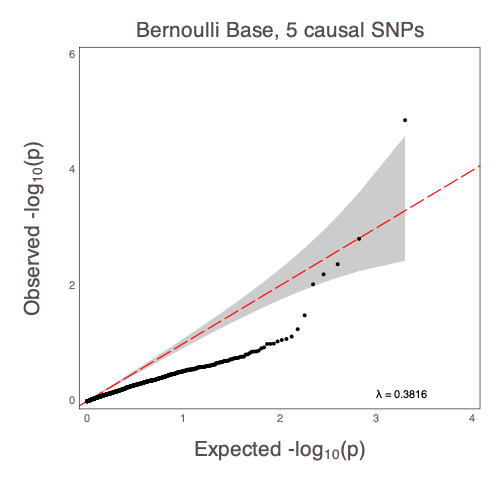

In [22]:
qq(pvals, dpi=100, titles="Bernoulli Base, 5 causal SNPs")
display("image/png", read("qqplot.png"))

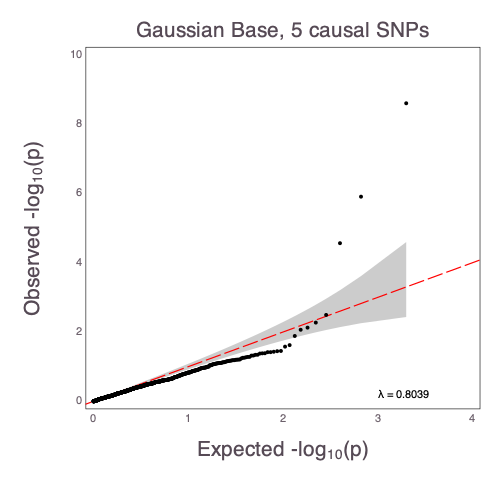

In [43]:
qq(pvals, dpi=100, titles="Gaussian Base, 5 causal SNPs")
display("image/png", read("qqplot.png"))

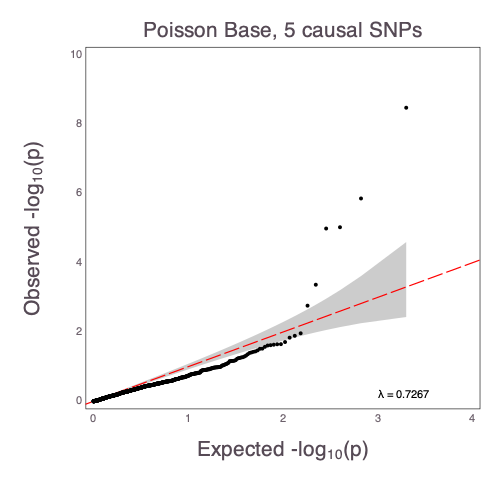

In [30]:
qq(pvals, dpi=100, titles="Poisson Base, 5 causal SNPs")
display("image/png", read("qqplot.png"))

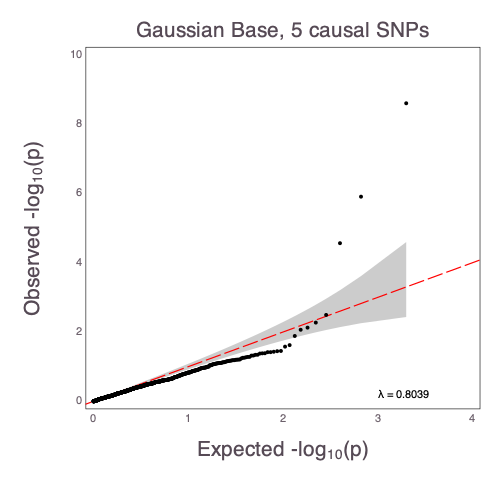

In [115]:
qq(pvals, dpi=100, titles="Gaussian Base, 5 causal SNPs")
display("image/png", read("qqplot.png"))

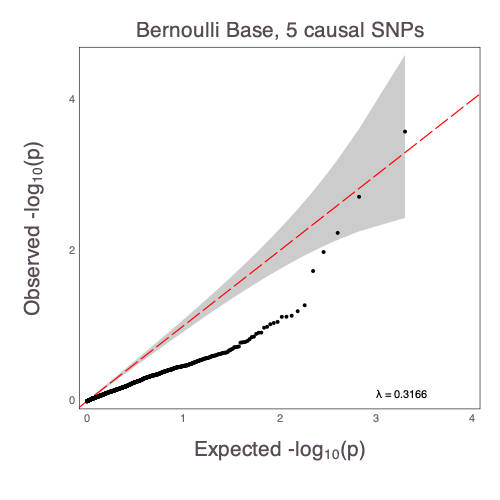

In [24]:
qq(pvals, dpi=100, titles="Bernoulli Base, 5 causal SNPs")
display("image/png", read("qqplot.png"))

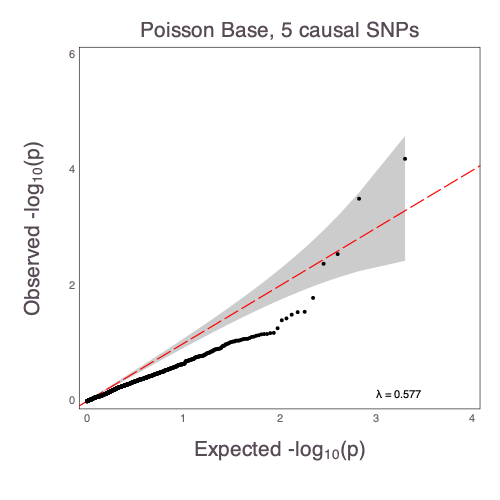

In [32]:
qq(pvals, dpi=100, titles="Poisson Base, 5 causal SNPs")
display("image/png", read("qqplot.png"))